In [1]:
import scanpy as sc
import gzip
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to the tissue_positions.parquet file
parquet_pth = "/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/spatial/tissue_positions.parquet"

# Load the Parquet file into a pandas DataFrame
tissue_positions_df = pd.read_parquet(parquet_pth)

tissue_positions_df.head()

tissue_positions_df_processed = tissue_positions_df[['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres']]

tissue_positions_df_processed.rename(columns={
    'barcode': 'Spot', 
    'pxl_row_in_fullres': 'x',  # Corrected to match the original column name
    'pxl_col_in_fullres': 'y'    # Corrected to match the original column name
}, inplace=True)

/tmp/ipykernel_3046869/4198475070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_positions_df_processed.rename(columns={


In [3]:
he_pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/spatial/tissue_hires_image.png'

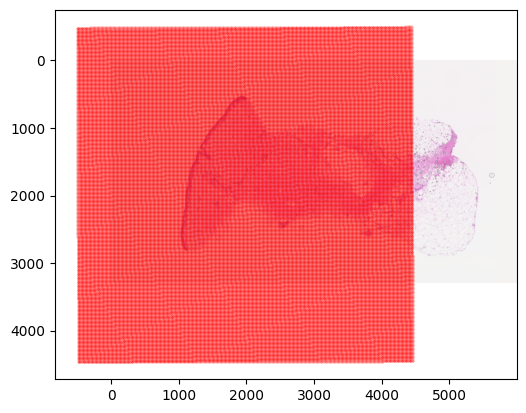

In [4]:
with Image.open(he_pth) as img:
    plt.imshow(img)

plt.scatter(tissue_positions_df_processed['x'], tissue_positions_df_processed['y'], s=0.01, color='red')  # Change color and size as needed


In [5]:
# load annotation data matrix
pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/filtered_feature_bc_matrix'

adata0 = sc.read_10x_mtx(pth, var_names='gene_symbols', cache=True)
adata1 = sc.read_10x_mtx(pth, var_names='gene_symbols', cache=True) # this one we will log
# Log-transform the data
sc.pp.log1p(adata1)

# need to filter the matrix cols (genes) since there are so many, we are only going to use top 1000 most
# variabbly expressed genes like they did in the paper

# Calculate highly variable genes
sc.pp.highly_variable_genes(adata1, n_top_genes=1000)

# now go back to unlogged data
filtered_raw_matrix = adata0.X[:,adata1.var['highly_variable']].toarray()

In [6]:
# Load barcodes (spot identifiers)
barcodes_file = os.path.join(pth, "barcodes.tsv.gz")

# Since the barcodes are gzipped, we'll read them using gzip
with gzip.open(barcodes_file, 'rt') as f:
    barcodes = [line.strip() for line in f.readlines()]

# Load gene names (features)
features_file = os.path.join(pth, "features.tsv.gz")
with gzip.open(features_file, 'rt') as f:
    features = [line.strip().split("\t")[1] for line in f.readlines()]

highly_var = np.where(adata1.var['highly_variable'])[0].tolist()
features = [features[i] for i in highly_var]

In [7]:
# Step 5: Convert raw matrix to a DataFrame and add barcodes and gene names
raw_matrix_df = pd.DataFrame(filtered_raw_matrix, index=barcodes, columns=features)

raw_matrix_df.head()

,PLEKHN1,AGRN,TTLL10,ACAP3,CCNL2,PLCH2,PLEKHG5,CA6,CLSTN1,CTNNBIP1,...,PLS3,AGTR2,PLAC1,FLNA,SPRY3,NLGN4Y,MT-ND1,MT-ATP6,MT-ND4L,MT-ND6
s_016um_00052_00082-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00010_00367-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00396_00063-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00144_00175-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00297_00147-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
raw_matrix_df.shape

(118049, 1000)

In [9]:
tissue_positions_df_processed.head()

,Spot,x,y
0,s_016um_00000_00000-1,-494.401792,4470.835938
1,s_016um_00000_00001-1,-494.439320,4458.975260
2,s_016um_00000_00002-1,-494.476849,4447.114583
3,s_016um_00000_00003-1,-494.514377,4435.253909
4,s_016um_00000_00004-1,-494.551906,4423.393237


In [10]:
intersected_spots = list(set(barcodes) & set(tissue_positions_df_processed['Spot'].tolist()))
print(len(intersected_spots))

# barcodes only
barcode_locs_df = tissue_positions_df_processed[tissue_positions_df_processed['Spot'].isin(intersected_spots)]

print(barcode_locs_df.shape)

118049
(118049, 3)


In [11]:
pth_scale_factors = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/spatial/scalefactors_json.json'

with open(pth_scale_factors, 'rb') as f:
    scale_factors = json.load(f)

In [12]:
tissue_hires_scalef = scale_factors['tissue_hires_scalef']

tissue_positions_df_processed2 = tissue_positions_df[['barcode', 'pxl_col_in_fullres', 'pxl_row_in_fullres']]

# adjust the scale
tissue_positions_df_processed2['pxl_col_in_fullres'] = tissue_positions_df_processed2['pxl_col_in_fullres'] * tissue_hires_scalef
tissue_positions_df_processed2['pxl_row_in_fullres'] = tissue_positions_df_processed2['pxl_row_in_fullres'] * tissue_hires_scalef

tissue_positions_df_processed2.rename(columns={
    'barcode': 'Spot', 
    'pxl_col_in_fullres': 'x',
    'pxl_row_in_fullres': 'y'
}, inplace=True)

barcode_locs_df2 = tissue_positions_df_processed2[tissue_positions_df_processed['Spot'].isin(intersected_spots)]

/tmp/ipykernel_3046869/3051937111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_positions_df_processed2['pxl_col_in_fullres'] = tissue_positions_df_processed2['pxl_col_in_fullres'] * tissue_hires_scalef
/tmp/ipykernel_3046869/3051937111.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_positions_df_processed2['pxl_row_in_fullres'] = tissue_positions_df_processed2['pxl_row_in_fullres'] * tissue_hires_scalef
/tmp/ipykernel_3046869/3051937111.py:9: SettingWithCopyWarning: 
A value is tryi

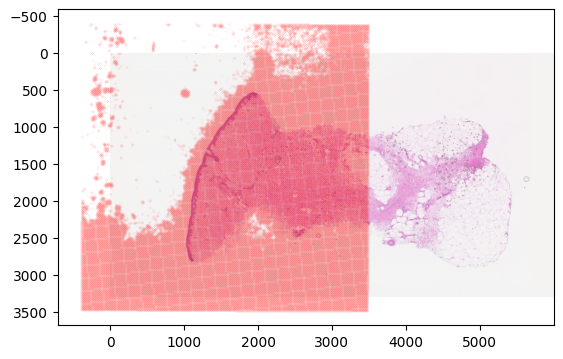

In [13]:
with Image.open(he_pth) as img:
    plt.imshow(img)

plt.scatter(barcode_locs_df2['x'], barcode_locs_df2['y'], s=0.001, color='red')  # Change color and size as needed


In [14]:
barcode_locs_df2.shape

(118049, 3)

In [15]:
cutoff = 20 # pixels inside of tissue 
mask = (barcode_locs_df2['x'] > cutoff) & (barcode_locs_df2['x'] < (img.width - cutoff)) & \
       (barcode_locs_df2['y'] > cutoff) & (barcode_locs_df2['y'] < (img.height - cutoff))

filtered_barcode_locs_df2= barcode_locs_df2[mask]

filtered_barcode_locs_df2.shape

(96588, 3)

In [21]:
out_folder = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/inputs'

output_raw_matrix = raw_matrix_df.loc[filtered_barcode_locs_df2['Spot'].tolist()]

outpth = os.path.join(out_folder, "cnts.tsv")
output_raw_matrix.to_csv(outpth, sep='\t')

In [23]:
print(output_raw_matrix.shape)
print(filtered_barcode_locs_df2.shape)

(96588, 1000)
(96588, 3)


In [24]:
outpth = os.path.join(out_folder, "locs-raw.tsv")
filtered_barcode_locs_df2.to_csv(outpth, sep='\t', index=False)

In [25]:
scale_factors

{'spot_diameter_fullres': 11.860326263441127,
 'bin_size_um': 16.0,
 'microns_per_pixel': 1.3490354012704704,
 'regist_target_img_scalef': 0.78125,
 'tissue_lowres_scalef': 0.078125,
 'fiducial_diameter_fullres': 244.61922918347324,
 'tissue_hires_scalef': 0.78125}

In [29]:
# I have to work with this subpar highres image, which was downsampled and thus is not 20x
# tissue_hires_scalef

# Given values from the scale factors
spot_diameter_um = scale_factors['spot_diameter_fullres']
microns_per_pixel = scale_factors['microns_per_pixel']

# Calculate the radius in micrometers
spot_radius_um = spot_diameter_um / 2

# Calculate the radius in pixels
spot_radius_pixels = (spot_radius_um / microns_per_pixel)

# Output the results
print(f"Spot Radius in Pixels: {spot_radius_pixels}")
print(f"Pixel Size: {microns_per_pixel / tissue_hires_scalef}")

outpth_pixel_size = os.path.join(out_folder, 'pixel-size-raw.txt')
with open(outpth_pixel_size, 'w') as f:
    f.write(str(microns_per_pixel / tissue_hires_scalef))

outpth_radius_size = os.path.join(out_folder, 'radius-raw.txt')
with open(outpth_radius_size, 'w') as f:
    f.write(str(spot_diameter_um))

Spot Radius in Pixels: 4.39585434610223
Pixel Size: 1.726765313626202


In [27]:
output_jpg_path = "/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/inputs/he-raw.jpg"

pth_im = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/spatial/tissue_hires_image.png'

# Open the PNG image
with Image.open(pth_im) as img:
    # Convert the image to RGB (JPEG does not support transparency)
    rgb_img = img.convert('RGB')
    
    # Save the image as JPG
    rgb_img.save(output_jpg_path, format='JPEG')